In [1]:
%load_ext autoreload

In [2]:
%autoreload 2
%aimport emc
%aimport kdimuon
%aimport spill

In [3]:
%matplotlib inline

In [4]:
from emc import *
from kdimuon import *
from spill import *
import scipy as sp
from scipy import stats
import matplotlib.pylab as pylab
import matplotlib.gridspec as gridspec
import seaborn as sns
import uncertainties as unc

sys.path.append('../modules')
from targets import target_dict

In [5]:
pylab.rcParams['figure.figsize'] = 12, 8  # that's default image size for this interactive session

### Objectives
1. Create analysis schema and table
2. Get xT array and number of live protons for each target
3. Get histogram counts and error for each target
4. Get PDF's for each distribution
4. Subtract Empty from LD2 and LH2 counts, combine error
5. Use LH2 and LD2 data, proportions, to get Deuterium counts, error
6. Plot distributions for all targets, including LD2 / D2
7. Calculate ratio values, error values, plot

In [6]:
server = 'e906-db3.fnal.gov'
analysis_schema = 'user_dannowitz_analysis_CrossCheck'
merged_schema_list = ['merged_roadset59_R004_V005'] #, 'merged_roadset59_R004_V003']
#merged_schema_list = ['merged_roadset59_R004_V003']
analysis_table = 'kDimuon59'
fresh_start = True

### Make table with all appropriate cuts and create dictionary of xT values for each target

In [58]:
# If True, then it will clear out the existing analysis table
#fresh_start = False
fresh_start = True

In [7]:
# 1. Create analysis schema and table
if not schema_exists(server, analysis_schema):
    make_analysis_schema(server, analysis_schema)
if not table_exists(server, analysis_schema, analysis_table):
    make_kDimuon_table(server, analysis_schema, analysis_table, merged_schema_list[0])

if fresh_start:
    drop_analysis_table(server, analysis_schema, analysis_table)
    make_kDimuon_table(server, analysis_schema, analysis_table, merged_schema_list[0])

In [8]:
# Fill with data from merged schemas, apply all cuts in the process
if fresh_start:
    for merged_schema in merged_schema_list:
        fill_kDimuon_table(server, analysis_schema, analysis_table, merged_schema)

196346 entries copied over with mass between 4.2 and 10 GeV and chisq<25
1424 entries deleted for x-range cuts
189590 entries deleted for dimuon positional and momentum cuts
1739 Rows deleted for track-level cuts
1302 Rows deleted for dump radius cut
Got 2291 dimuons to work with.
Cuts applied, target position populated. Begin Analysis!


In [9]:
# Get the distinct set of 'bad spills' from the merged productions
if fresh_start:
    bad_spill_set = set()
    for merged_schema in merged_schema_list:
        print merged_schema + ' Bad Spill Check:'
        bad_spill_merge_set = get_bad_spills(server, merged_schema)
        print str(len(bad_spill_merge_set)) + ' Distinct Bad Spills From ' + merged_schema
        bad_spill_set |= bad_spill_merge_set
    write_bad_spills_to_table(server, analysis_schema, bad_spill_set, clear=True)

else:
    bad_spill_set = get_bad_spills_from_table(server, analysis_schema)
    
print str(len(bad_spill_set)) + ' Total Bad Spills'

merged_roadset59_R004_V005 Bad Spill Check:
17 Spills where Spill.targetPos != Target.TARGPOS_CONTROL
2 Spills where Spill.targetPos Not Between 1 and 7
449 Spills where Scaler's TSGo Not Between 1e3 and 8e3
503 Spills where Scaler's AcceptedMatrix1 Not Between 1e3 and 8e3
504 Spills where Scaler's AfterInhMatrix1 Not Between 1e3 and 3e4
463 Spills where Scaler's AcceptedMatrix1/AfterInhMatrix1 Not Between 0.2 and 0.9
688 Spills where BeamDAQ's NM3ION Not Between 2e12 and 1e14
401 Spills where Beam's S:G2SEM Not Between 2e12 and 1e14
682 Spills where BeamDAQ's QIESum Not Between 4e10 and 1e12
580 Spills where BeamDAQ's inhibit_block_sum Not Between 4e9 and 1e11
822 Spills where BeamDAQ's trigger_sum_no_inhibit Not Between 4e9 and 1e11
695 Spills where BeamDAQ's dutyfactor53MHz Not Between 15 and 90
224 Spills with duplicate values
1133 Spills with missing value(s)
2264 Distinct Bad Spills From merged_roadset59_R004_V005
2264 Total Bad Spills


In [61]:
# Delete dimuon data for the bad spills
deleted_rows = clear_bad_spill_dimuons(server, analysis_schema, analysis_table, bad_spill_set)
print str(deleted_rows) + ' dimuons removed due to bad spill conditions.'

241 dimuons removed due to bad spill conditions.


In [17]:
# Delete dimuon data for Events that are not MATRIX1=1
deleted_rows = 0
for merged_schema in merged_schema_list:
    deleted_rows += clear_bad_event_dimuons(server, analysis_schema, analysis_table, merged_schema)

print str(deleted_rows) + ' dimuons removed due to bad event conditions.'

0 dimuons removed due to bad event conditions.


In [18]:
# 2. Get xT array and number of live protons for each target

xT_dict = {}
live_p_dict = {}
for target in target_dict:
    
    # xT values by target
    xT_dict[target] = get_xT(server, analysis_schema, analysis_table, target_dict[target]['targpos'])
    xT_dict[target].sort()
    
    live_p_dict[target] = 0.0
    for merged_schema in merged_schema_list:
        # Live proton count (in units of 10^16 live protons)
        live_p_dict[target] += get_live_p_1016(server, analysis_schema, merged_schema,
                                               target_dict[target]['targpos'], bad_spill_set)
    
    print target, ': N =', len(xT_dict[target]), ', live_p:', round(live_p_dict[target],3), 'x 10^16'

None : N = 55 , live_p: 0.69 x 10^16
C : N = 1706 , live_p: 1.377 x 10^16
LD2 : N = 3371 , live_p: 2.169 x 10^16
LH2 : N = 2984 , live_p: 4.367 x 10^16
W : N = 1525 , live_p: 0.456 x 10^16
Empty : N = 63 , live_p: 0.477 x 10^16
Fe : N = 1318 , live_p: 0.445 x 10^16


In [44]:
xT_dict, live_p_dict = get_xT_livep_dicts()

12528 Total Bad Spills
0 dimuons removed due to bad spill conditions.
0 dimuons removed due to bad event conditions.
None : N = 55 , live_p: 0.69 x 10^16
C : N = 1706 , live_p: 1.377 x 10^16
LD2 : N = 3371 , live_p: 2.169 x 10^16
LH2 : N = 2984 , live_p: 4.367 x 10^16
W : N = 1525 , live_p: 0.456 x 10^16
Empty : N = 63 , live_p: 0.477 x 10^16
Fe : N = 1318 , live_p: 0.445 x 10^16


In [19]:
# 3. Get histogram counts and error for each target

n_bins = 20
max_x = 1.0
min_x = 0.0
bin_width = (float(max_x) - float(min_x)) / float(n_bins)
print 'Bin Width: ' + str(bin_width)

hist_dict = {}
for target in xT_dict:
    ucounts, centers = get_hist_vals(xT_dict[target], live_p_dict[target], n_bins, min_x, max_x)
    hist_dict[target] = {'ucounts': ucounts, 'bin_centers': centers}

Bin Width: 0.05


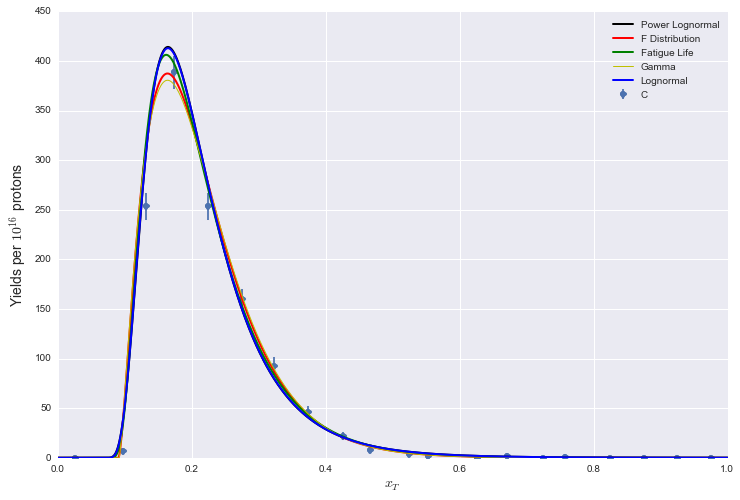

In [20]:
# Here, I try out different functional fits to the xT distribution
fig1, ax1 = plt.subplots(1, 1)

count_sum = len(xT_dict['C'])
pdf_scale = bin_width * count_sum / live_p_dict['C']
xT_C = [xT for xT in xT_dict['C']]
x = np.linspace(0.0, 1.0, 1000)

# Plot the data points for yields per 10^16 live protons
ax1.errorbar(unp.nominal_values(hist_dict['C']['bin_centers']), 
             unp.nominal_values(hist_dict['C']['ucounts']),
             yerr=unp.std_devs(hist_dict['C']['ucounts']), 
             label='C', fmt='o')

# Fit a Power Lognormal function to the xT distribution
#   Adjust it with the pdf_scale parameter
c, s, loc, scale = sp.stats.powerlognorm.fit(xT_C)
rv1 = sp.stats.powerlognorm(c=c, s=s, scale=scale, loc=loc)
ax1.plot(x, rv1.pdf(x)*pdf_scale, 'k-', lw=2, label='Power Lognormal')

dfn, dfd, loc, scale = sp.stats.f.fit(xT_C)
rv2 = sp.stats.f(dfn=dfn, dfd=dfd, scale=scale, loc=loc)
ax1.plot(x, rv2.pdf(x)*pdf_scale, 'r-', lw=2, label='F Distribution')

c, loc, scale = sp.stats.fatiguelife.fit(xT_C)
rv3 = sp.stats.fatiguelife(c=c, scale=scale, loc=loc)
ax1.plot(x, rv3.pdf(x)*pdf_scale, 'g-', lw=2, label='Fatigue Life')

a, loc, scale = sp.stats.gamma.fit(xT_C)
rv4 = sp.stats.gamma(a=a, scale=scale, loc=loc)
ax1.plot(x, rv4.pdf(x)*pdf_scale, 'y-', lw=1, label='Gamma')

s, loc, scale = sp.stats.lognorm.fit(xT_C)
rv5 = sp.stats.lognorm(s=s, scale=scale, loc=loc)
ax1.plot(x, rv5.pdf(x)*pdf_scale, 'b-', lw=2, label='Lognormal')

ax1.set_xlabel(r'$x_T$', fontsize=14)
ax1.set_ylabel(r'Yields per $10^{16}$ protons', fontsize=14)

ax1.legend(loc='best')

In [21]:
# Here, I find the lognormal fit for each *unbinned xT distribution*
# These PDF's are normalized to 1, so I also calculate the scale factor
#     for scaling them up the the histogram's size.

pdf_dict = {}
for target in target_dict:
    count_sum = len(xT_dict[target])
    pdf_scale = bin_width * count_sum / live_p_dict[target]
    s, loc, scale = sp.stats.lognorm.fit(xT_dict[target])
    rv = sp.stats.lognorm(s=s, scale=scale, loc=loc)
    pdf_dict[target] = {'pdf': rv, 'pdf_scale': pdf_scale}

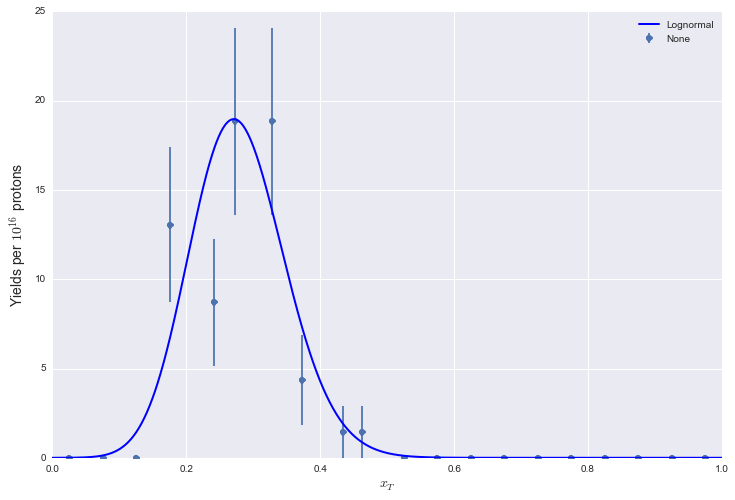

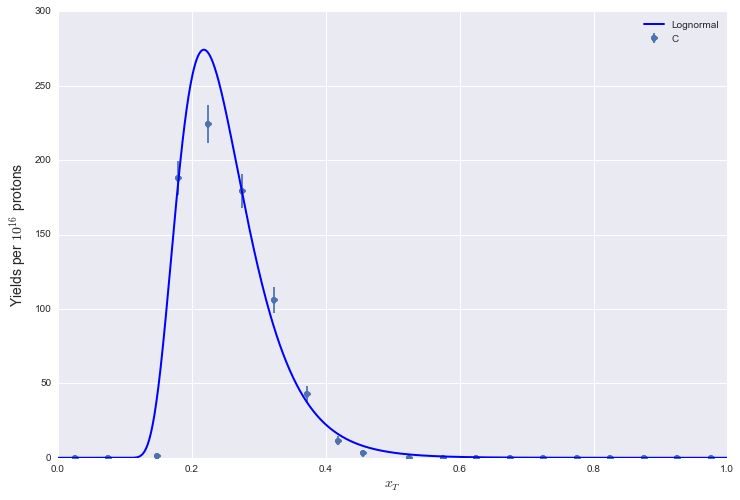

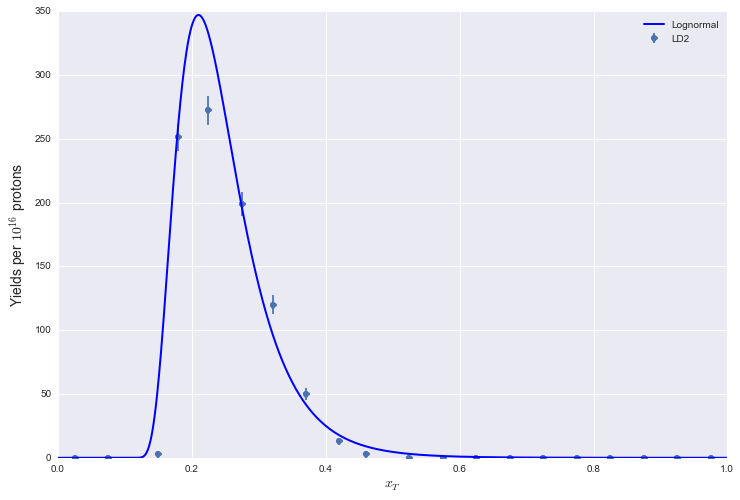

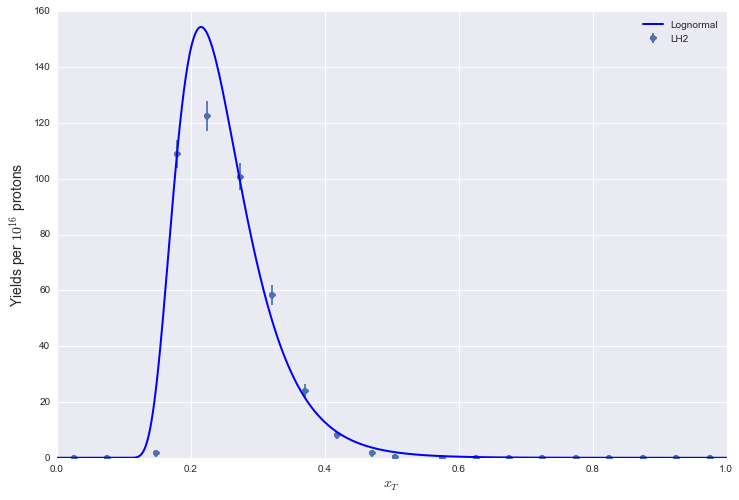

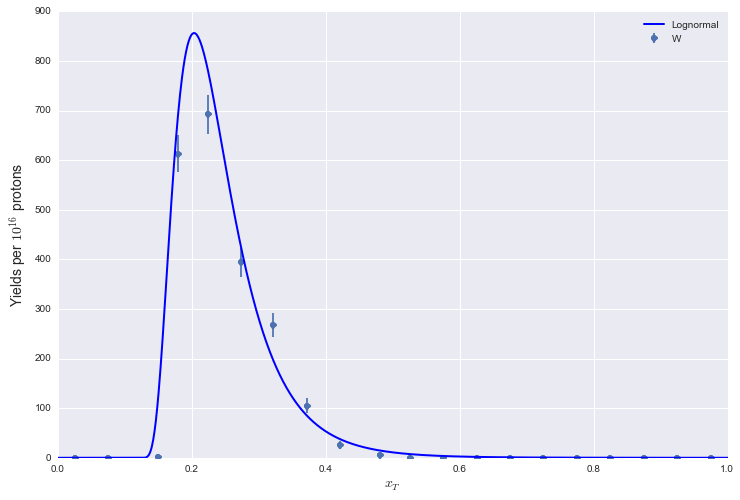

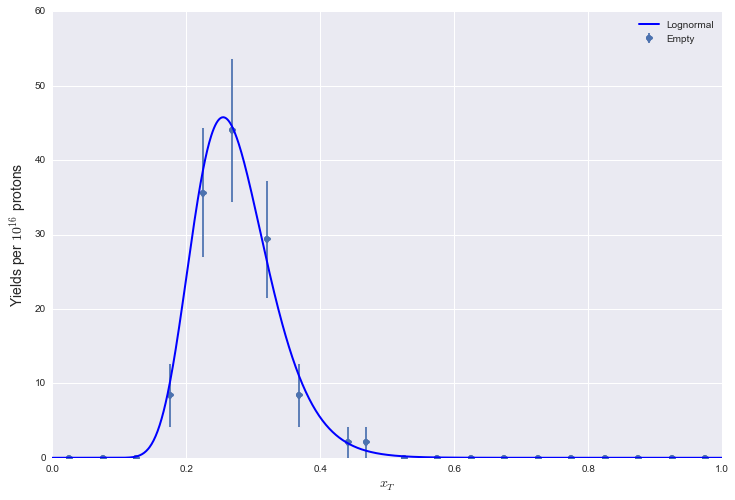

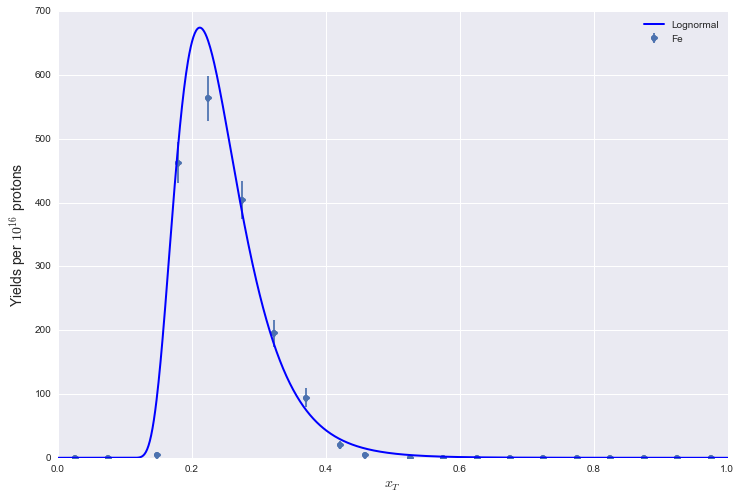

In [32]:
# Let's plot them, just for kicks.
x = np.linspace(0.0, 1.0, 1000)
for target in target_dict:
    # Plot the data points for yields per 10^16 live protons
    plt.errorbar(unp.nominal_values(hist_dict[target]['bin_centers']), 
                 unp.nominal_values(hist_dict[target]['ucounts']),
                 yerr=unp.std_devs(hist_dict[target]['ucounts']), 
                 label=target, fmt='o')
    plt.plot(x, pdf_dict[target]['pdf'].pdf(x)*pdf_dict[target]['pdf_scale'], 'b-', lw=2, label='Lognormal')
    
    plt.xlabel(r'$x_T$', fontsize=14)
    plt.ylabel(r'Yields per $10^{16}$ protons', fontsize=14)

    plt.legend(loc='best')
    
    plt.show()
    

In [97]:
# Now we make an instance of
# Move the bins towards each other, adjust them using their PDF's

for target in target_dict:
    if target not in ('None', 'Empty'):
        bin_centers = []
        hist_adjust = []
        hist_adjust2 = []
        if target in ('C', 'Fe', 'W'):
            subtract_target = 'None'
        elif target in ('LD2', 'LH2'):
            subtract_target = 'Empty'
        
        pdf = pdf_dict[target]['pdf']
        pdf_scale = pdf_dict[target]['pdf_scale']
        sub_pdf = pdf_dict[subtract_target]['pdf']
        sub_pdf_scale = pdf_dict[subtract_target]['pdf_scale']
        for i in range(n_bins):
            bin_centers.append((hist_dict[target]['bin_centers'][i] + hist_dict[subtract_target]['bin_centers'][i]) / 2.0)
            hist_adjust.append(pdf.pdf(hist_dict[target]['bin_centers'][i])*pdf_scale - 
                               pdf.pdf(bin_centers[i])*pdf_scale)
            hist_adjust2.append(sub_pdf.pdf(hist_dict[subtract_target]['bin_centers'][i])*sub_pdf_scale - 
                                sub_pdf.pdf(bin_centers[i])*sub_pdf_scale)
        
        
        hist_dict[target + "'"] = {'ucounts': hist_dict[target]['ucounts']-hist_adjust, 
                                   'bin_centers': bin_centers}
        subtract_target_dict = {'ucounts': hist_dict[subtract_target]['ucounts']-hist_adjust2, 
                                  'bin_centers': bin_centers}
        hist_dict[target + "'-" + subtract_target + "'"] = {'ucounts': hist_dict[target + "'"]['ucounts'] - 
                                                                 subtract_target_dict['ucounts'],
                                                            'bin_centers': bin_centers }
        del subtract_target_dict, bin_centers        

In [22]:
# 4. Subtract Empty counts from LD2 and LH2 counts
#    Subtract None counts from C, Fe, and W counts
#    Do *not* adjust the values
for target in target_dict:
    if target in ('LD2', 'LH2'):
        hist_dict[target + '-Empty'] = {'ucounts': hist_dict[target]['ucounts'] - 
                                        unp.uarray((pdf_dict['Empty']['pdf'].pdf(hist_dict[target]['bin_centers'])*
                                        pdf_dict['Empty']['pdf_scale']),unp.std_devs(hist_dict['Empty']['ucounts'])),
                                        'bin_centers': hist_dict[target]['bin_centers']}
    if target in ('Fe', 'W', 'C'):
        hist_dict[target + '-None'] = {'ucounts': hist_dict[target]['ucounts'] - 
                                       unp.uarray((pdf_dict['None']['pdf'].pdf(hist_dict[target]['bin_centers'])*
                                       pdf_dict['None']['pdf_scale']),unp.std_devs(hist_dict['None']['ucounts'])),
                                       'bin_centers': hist_dict[target]['bin_centers']}   

In [23]:
# Do a bit of data cleaning. If a subtraction or adjustment moved anything to be
#    less than zero, set it to zero.
for target, hist in hist_dict.iteritems():
    hist['ucounts'] = [ucount if unp.nominal_values(ucount)>0 else unc.ufloat(0.0,0.0) for ucount in hist['ucounts']]

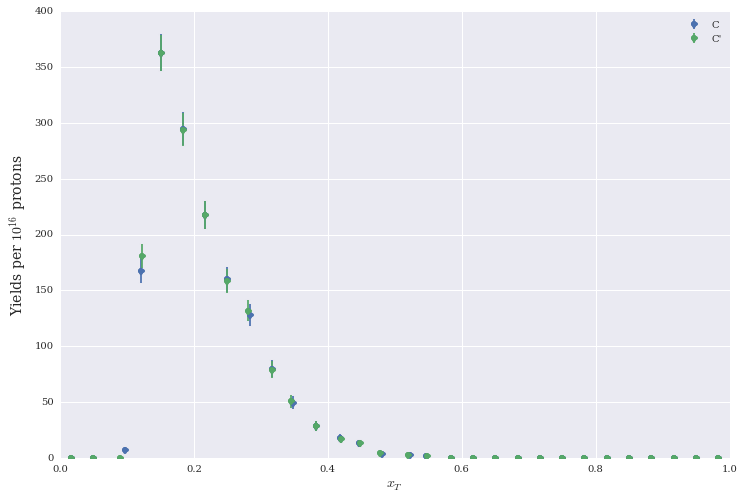

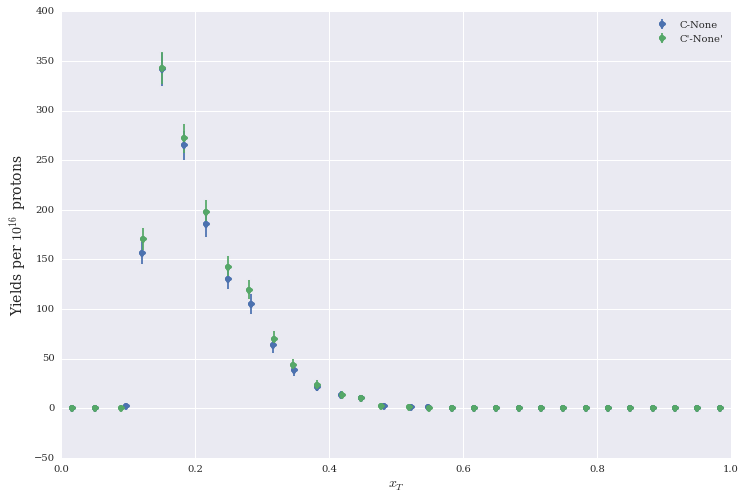

In [108]:
plt.errorbar(unp.nominal_values(hist_dict['C']['bin_centers']), 
                 unp.nominal_values(hist_dict['C']['ucounts']),
                 yerr=unp.std_devs(hist_dict['C']['ucounts']), 
                 label='C', fmt='o')
plt.errorbar(unp.nominal_values(hist_dict["C'"]['bin_centers']), 
                 unp.nominal_values(hist_dict["C'"]['ucounts']),
                 yerr=unp.std_devs(hist_dict["C'"]['ucounts']), 
                 label='C\'', fmt='o')
plt.xlabel(r'$x_T$', fontsize=14)
plt.ylabel(r'Yields per $10^{16}$ protons', fontsize=14)
plt.legend(loc='best')
plt.show()

plt.errorbar(unp.nominal_values(hist_dict["C-None"]['bin_centers']), 
                 unp.nominal_values(hist_dict["C-None"]['ucounts']),
                 yerr=unp.std_devs(hist_dict["C-None"]['ucounts']), 
                 label='C-None', fmt='o')
plt.errorbar(unp.nominal_values(hist_dict["C'-None'"]['bin_centers']), 
                 unp.nominal_values(hist_dict["C'-None'"]['ucounts']),
                 yerr=unp.std_devs(hist_dict["C'-None'"]['ucounts']), 
                 label='C\'-None\'', fmt='o')

plt.xlabel(r'$x_T$', fontsize=14)
plt.ylabel(r'Yields per $10^{16}$ protons', fontsize=14)
plt.legend(loc='best')
plt.show()

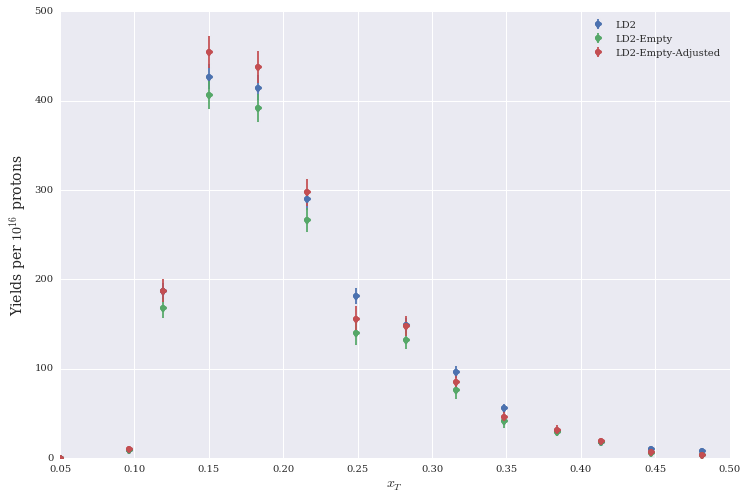

In [218]:
plt.errorbar(unp.nominal_values(hist_dict["LD2"]['bin_centers']), 
                 unp.nominal_values(hist_dict["LD2"]['ucounts']),
                 yerr=unp.std_devs(hist_dict["LD2"]['ucounts']), 
                 label='LD2', fmt='o')
plt.errorbar(unp.nominal_values(hist_dict["LD2-Empty"]['bin_centers']), 
                 unp.nominal_values(hist_dict["LD2-Empty"]['ucounts']),
                 yerr=unp.std_devs(hist_dict["LD2-Empty"]['ucounts']), 
                 label='LD2-Empty', fmt='o')
plt.errorbar(unp.nominal_values(hist_dict["LD2-Empty-Adjusted"]['bin_centers']), 
                 unp.nominal_values(hist_dict["LD2-Empty-Adjusted"]['ucounts']),
                 yerr=unp.std_devs(hist_dict["LD2-Empty-Adjusted"]['ucounts']), 
                 label='LD2-Empty-Adjusted', fmt='o')

plt.xlabel(r'$x_T$', fontsize=14)
plt.ylabel(r'Yields per $10^{16}$ protons', fontsize=14)
plt.legend(loc='best')
plt.xlim([0.05, 0.5])
plt.ylim([0,None])
plt.show()

### Take the LD2 Target impurity into account
* LH2_target = a*H + b*D
* LD2_target = c*H + d*D
* H2 = (d*LH2_target - b*LD2_target)/(da - bc)
* D2 = (a*LD2_target - c*LH2_target)/(da - bc)

In [24]:
# 5. Use LH2 and LD2 data, proportions, to get Deuterium counts
    
a = 1.00
b = 0.00
c = 0.0714
d = 0.9152
scale = 1.0 / (c+d)
c = scale*c
d = scale*d

# Construct revised Deuteron target counts
hist_dict['LD2-Empty-Adjusted'] = {'ucounts': np.multiply(np.multiply(hist_dict['LD2-Empty']['ucounts'],a) - 
                                              np.multiply(hist_dict['LH2-Empty']['ucounts'],c),(1/(d*a - b*c))),
                                  'bin_centers': hist_dict['LD2-Empty']['bin_centers']}

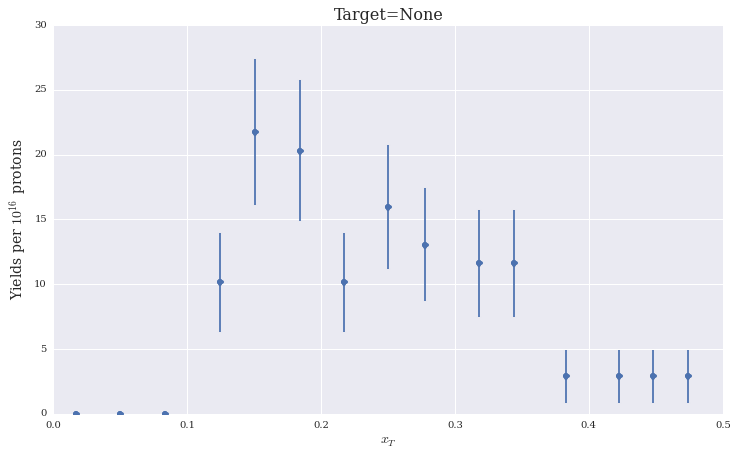

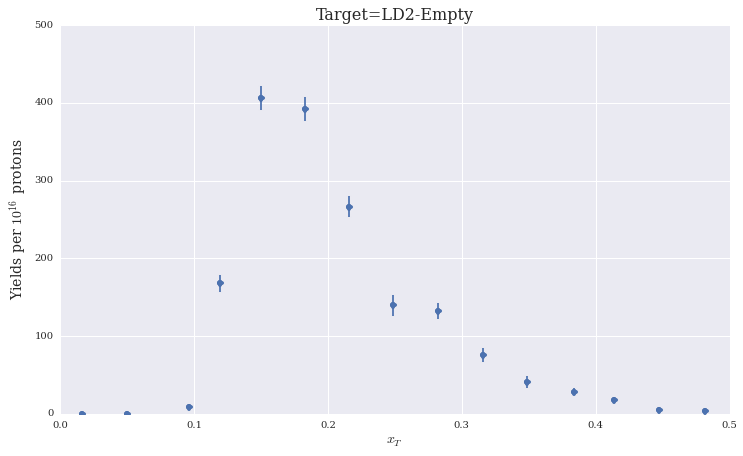

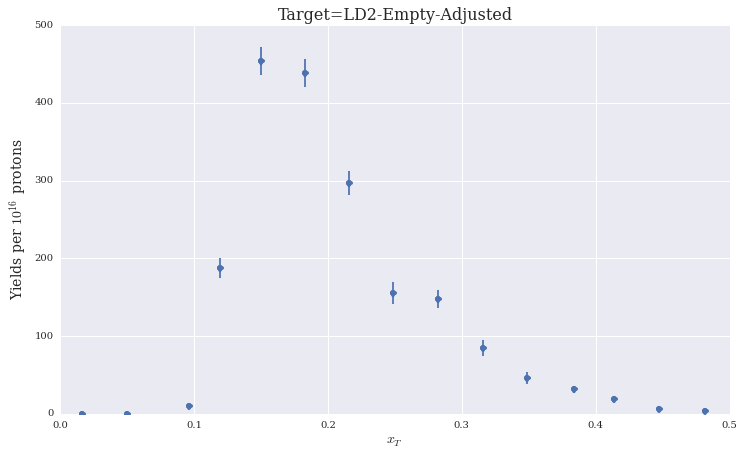

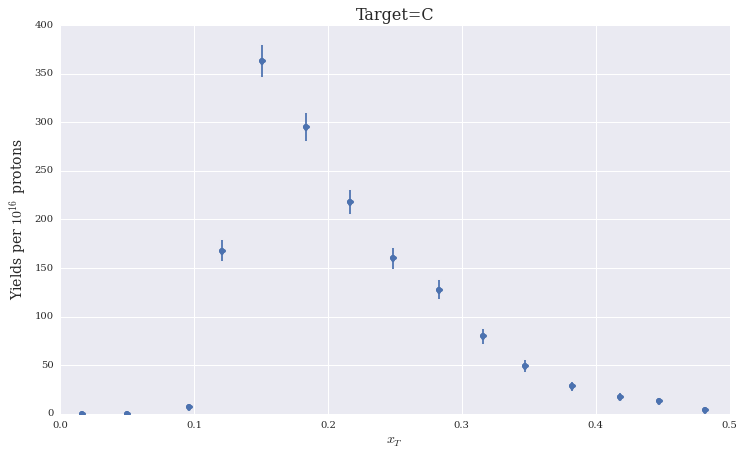

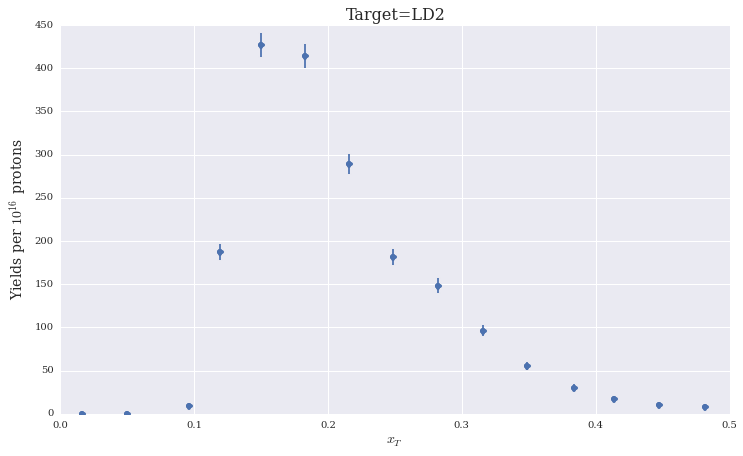

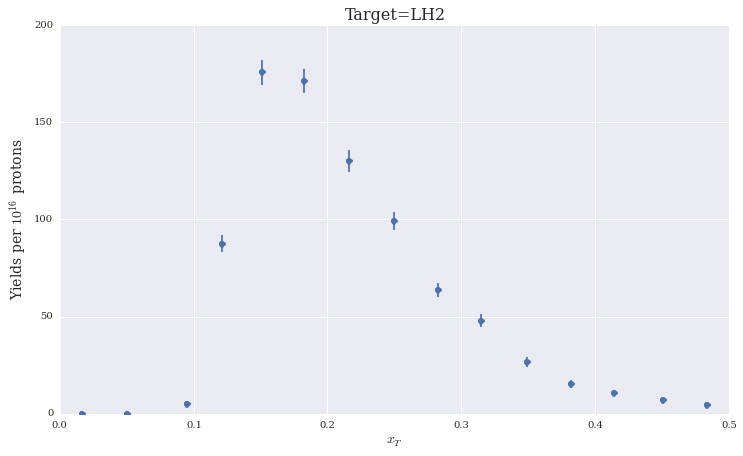

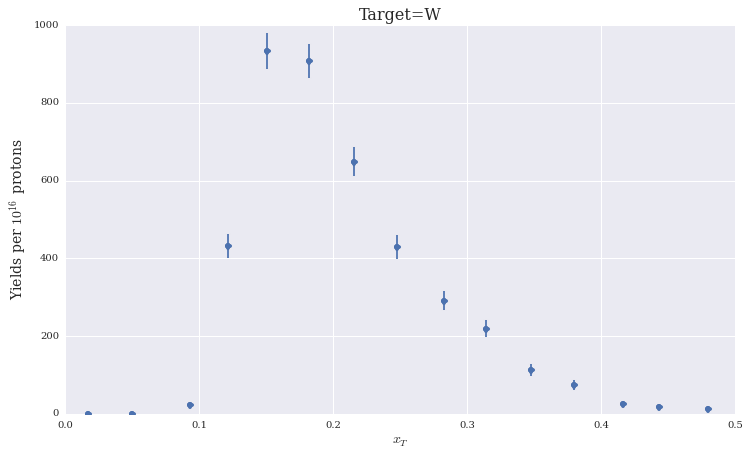

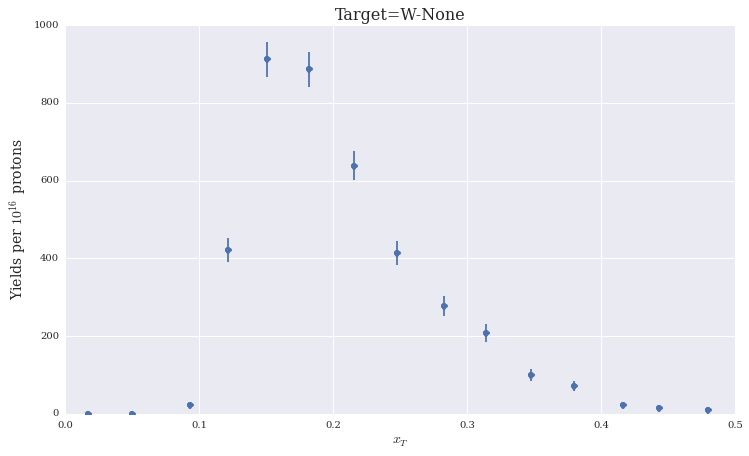

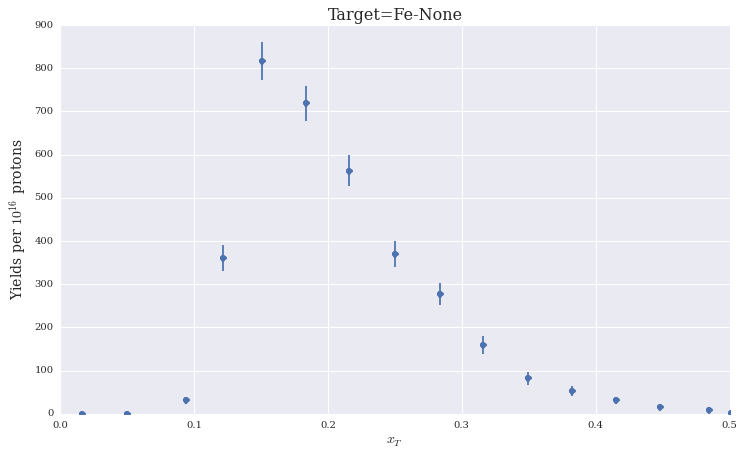

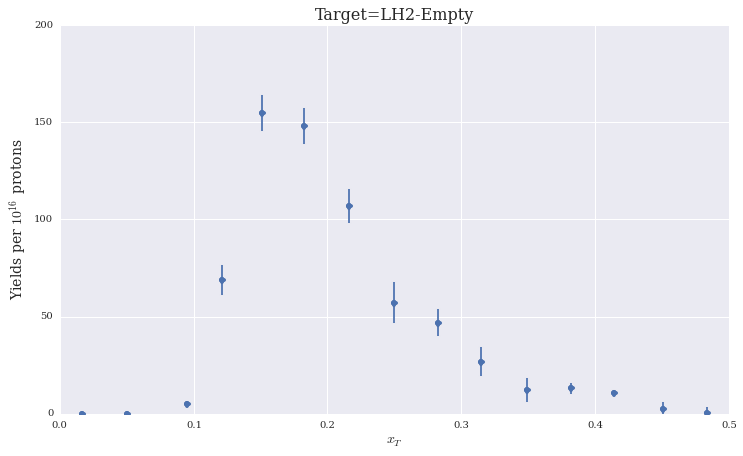

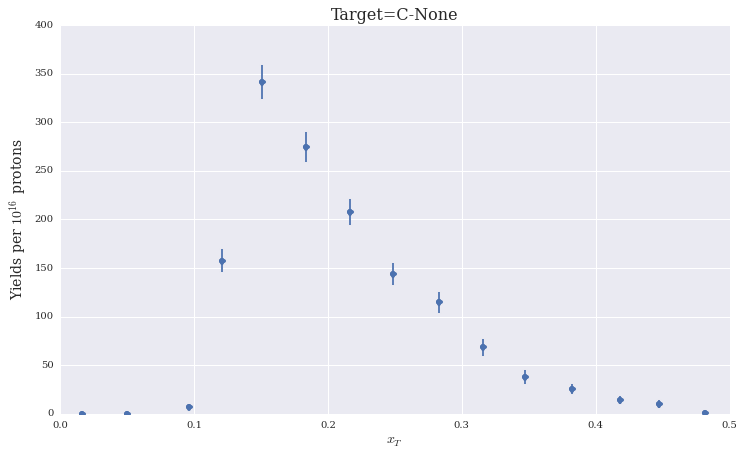

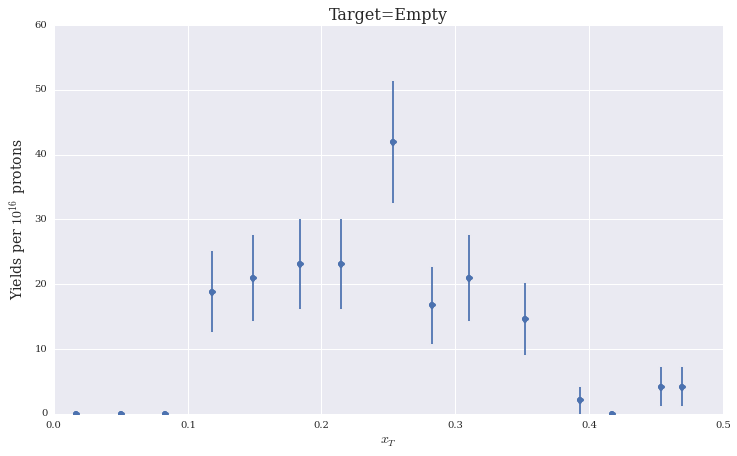

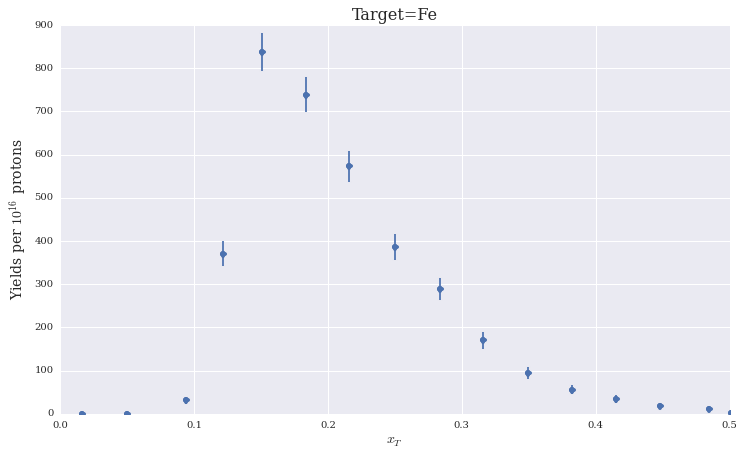

In [213]:
# 6. Plot distributions for all targets, including LD2 / D2
for target in hist_dict:
    plot_distribution(hist_dict[target]['ucounts'], hist_dict[target]['bin_centers'], target)

In [117]:
# 7. Calculate ratio values, error values, plot
d2_h2_ratio = get_ratio(hist_dict['LH2-Empty']['ucounts'], target_dict['LH2']['scale'],
                        hist_dict['LD2-Empty-Adjusted']['ucounts'], target_dict['LD2']['scale'])

In [25]:
c_d2_ratio = get_ratio(hist_dict['LD2-Empty-Adjusted']['ucounts'], target_dict['LD2']['scale'],
                        hist_dict['C-None']['ucounts'], target_dict['C']['scale'])
fe_d2_ratio = get_ratio(hist_dict['LD2-Empty-Adjusted']['ucounts'], target_dict['LD2']['scale'],
                        hist_dict['Fe-None']['ucounts'], target_dict['Fe']['scale'])
w_d2_ratio = get_ratio(hist_dict['LD2-Empty-Adjusted']['ucounts'], target_dict['LD2']['scale'],
                       hist_dict['W-None']['ucounts'], target_dict['W']['scale'])

In [40]:
c_d2_ratio = get_ratio(hist_dict['LD2-Empty']['ucounts'], target_dict['LD2']['scale'],
                        hist_dict['C-None']['ucounts'], target_dict['C']['scale'])
fe_d2_ratio = get_ratio(hist_dict['LD2-Empty']['ucounts'], target_dict['LD2']['scale'],
                        hist_dict['Fe-None']['ucounts'], target_dict['Fe']['scale'])
w_d2_ratio = get_ratio(hist_dict['LD2-Empty']['ucounts'], target_dict['LD2']['scale'],
                       hist_dict['W-None']['ucounts'], target_dict['W']['scale'])

KeyError: 'LD2-Empty-Adjusted'

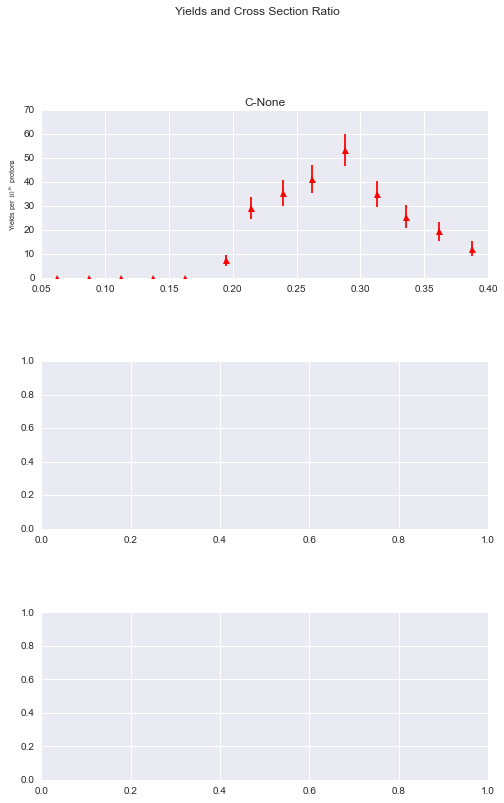

In [41]:
pylab.rcParams['figure.figsize'] = 8, 12  # that's default image size for this interactive session

fig1 = plt.figure()
gs = gridspec.GridSpec(6, 2)
gs.update(hspace=2.0)
ax0 = fig1.add_subplot(gs[0:2, :])
ax1 = fig1.add_subplot(gs[2:4, :])
ax2 = fig1.add_subplot(gs[4:, :])
fig1.suptitle('Yields and Cross Section Ratio', size=12, y=1.02)

# Plot the Carbon counts
ax0.errorbar(hist_dict['C-None']['bin_centers'], unp.nominal_values(hist_dict['C-None']['ucounts']),
             yerr=unp.std_devs(hist_dict['C-None']['ucounts']), fmt='^', color='r')
ax0.set_title('C-None')
ax0.set_ylabel(r'Yields per $10^{16}$ protons', fontsize=7)
ax0.set_ylim([0, None])
ax0.set_xlim([0.05, 0.4])

# Plot the LD2 counts
ax1.errorbar(hist_dict['LD2-Empty-Adjusted']['bin_centers'], unp.nominal_values(hist_dict['LD2-Empty-Adjusted']['ucounts']),
             yerr=unp.std_devs(hist_dict['LD2-Empty-Adjusted']['ucounts']), fmt='o', color='b')
ax1.set_title('LD2-Empty-Reduced')
ax1.set_ylabel(r'Yields per $10^{16}$ protons', fontsize=7)
ax1.set_ylim([0, None])
ax1.set_xlim([0.05, 0.4])

# Plot the ratio of the two
ax2.errorbar(hist_dict['LD2-Empty-Adjusted']['bin_centers'], unp.nominal_values(c_d2_ratio),
             yerr=unp.std_devs(c_d2_ratio), label='C / D2', fmt='s', color='g')
ax2.set_ylim([0.0, 2.0])
ax2.set_xlim([0.05, 0.4])
ax2.set_title('C / D2')
ax2.set_xlabel(r'$x_T$', fontsize=16)
ax2.axhline(y=1, c='red', linewidth=0.5)


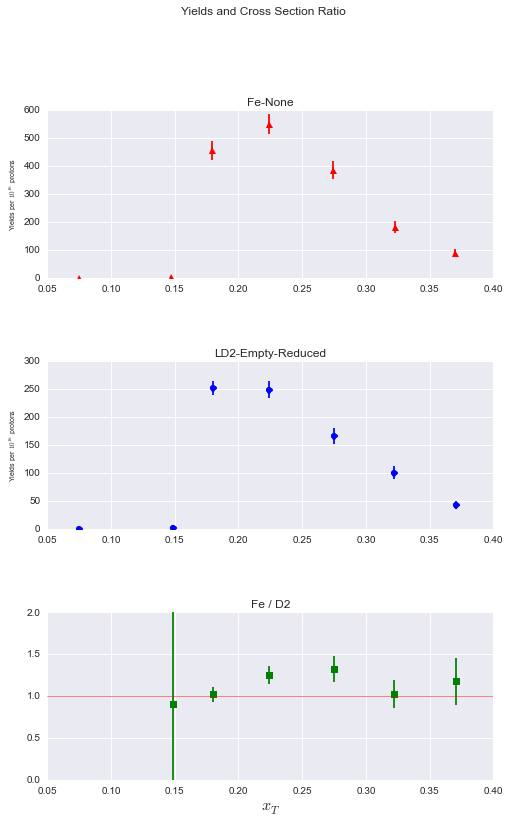

In [38]:
pylab.rcParams['figure.figsize'] = 8, 12  # that's default image size for this interactive session

fig1 = plt.figure()
gs = gridspec.GridSpec(6, 2)
gs.update(hspace=2.0)
ax0 = fig1.add_subplot(gs[0:2, :])
ax1 = fig1.add_subplot(gs[2:4, :])
ax2 = fig1.add_subplot(gs[4:, :])
fig1.suptitle('Yields and Cross Section Ratio', size=12, y=1.02)

# Plot the Carbon counts
ax0.errorbar(hist_dict['Fe-None']['bin_centers'], unp.nominal_values(hist_dict['Fe-None']['ucounts']),
             yerr=unp.std_devs(hist_dict['Fe-None']['ucounts']), fmt='^', color='r')
ax0.set_title('Fe-None')
ax0.set_ylabel(r'Yields per $10^{16}$ protons', fontsize=7)
ax0.set_ylim([0, None])
ax0.set_xlim([0.05, 0.4])

# Plot the LD2 counts
ax1.errorbar(hist_dict['LD2-Empty-Adjusted']['bin_centers'], unp.nominal_values(hist_dict['LD2-Empty-Adjusted']['ucounts']),
             yerr=unp.std_devs(hist_dict['LD2-Empty-Adjusted']['ucounts']), fmt='o', color='b')
ax1.set_title('LD2-Empty-Reduced')
ax1.set_ylabel(r'Yields per $10^{16}$ protons', fontsize=7)
ax1.set_ylim([0, None])
ax1.set_xlim([0.05, 0.4])

# Plot the ratio of the two
ax2.errorbar(hist_dict['LD2-Empty-Adjusted']['bin_centers'], unp.nominal_values(fe_d2_ratio),
             yerr=unp.std_devs(fe_d2_ratio), label='Fe / D2', fmt='s', color='g')
ax2.set_ylim([0.0, 2.0])
ax2.set_xlim([0.05, 0.4])
ax2.set_title('Fe / D2')
ax2.set_xlabel(r'$x_T$', fontsize=16)
ax2.axhline(y=1, c='red', linewidth=0.5)


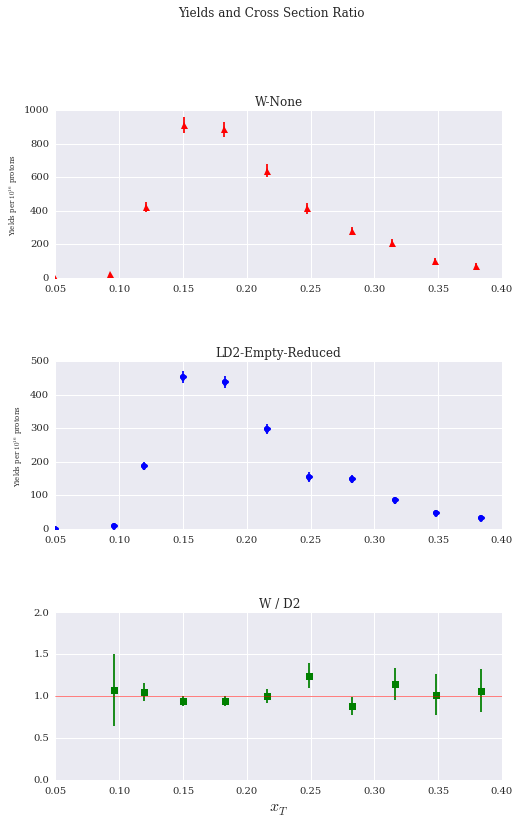

In [209]:
pylab.rcParams['figure.figsize'] = 8, 12  # that's default image size for this interactive session

fig1 = plt.figure()
gs = gridspec.GridSpec(6, 2)
gs.update(hspace=2.0)
ax0 = fig1.add_subplot(gs[0:2, :])
ax1 = fig1.add_subplot(gs[2:4, :])
ax2 = fig1.add_subplot(gs[4:, :])
fig1.suptitle('Yields and Cross Section Ratio', size=12, y=1.02)

# Plot the Carbon counts
ax0.errorbar(hist_dict['W-None']['bin_centers'], unp.nominal_values(hist_dict['W-None']['ucounts']),
             yerr=unp.std_devs(hist_dict['W-None']['ucounts']), fmt='^', color='r')
ax0.set_title('W-None')
ax0.set_ylabel(r'Yields per $10^{16}$ protons', fontsize=7)
ax0.set_ylim([0, None])
ax0.set_xlim([0.05, 0.4])

# Plot the LD2 counts
ax1.errorbar(hist_dict['LD2-Empty-Adjusted']['bin_centers'], unp.nominal_values(hist_dict['LD2-Empty-Adjusted']['ucounts']),
             yerr=unp.std_devs(hist_dict['LD2-Empty-Adjusted']['ucounts']), fmt='o', color='b')
ax1.set_title('LD2-Empty-Reduced')
ax1.set_ylabel(r'Yields per $10^{16}$ protons', fontsize=7)
ax1.set_ylim([0, None])
ax1.set_xlim([0.05, 0.4])

# Plot the ratio of the two
ax2.errorbar(hist_dict['LD2-Empty-Adjusted']['bin_centers'], unp.nominal_values(w_d2_ratio),
             yerr=unp.std_devs(w_d2_ratio), label='W / D2', fmt='s', color='g')
ax2.set_ylim([0.0, 2.0])
ax2.set_xlim([0.05, 0.4])
ax2.set_title('W / D2')
ax2.set_xlabel(r'$x_T$', fontsize=16)
ax2.axhline(y=1, c='red', linewidth=0.5)

In [ ]:
plot_ratio(d2_h2_ratio, hist_dict['LD2-Empty-Adjusted']['bin_centers'], 'LH2', 'LD2')

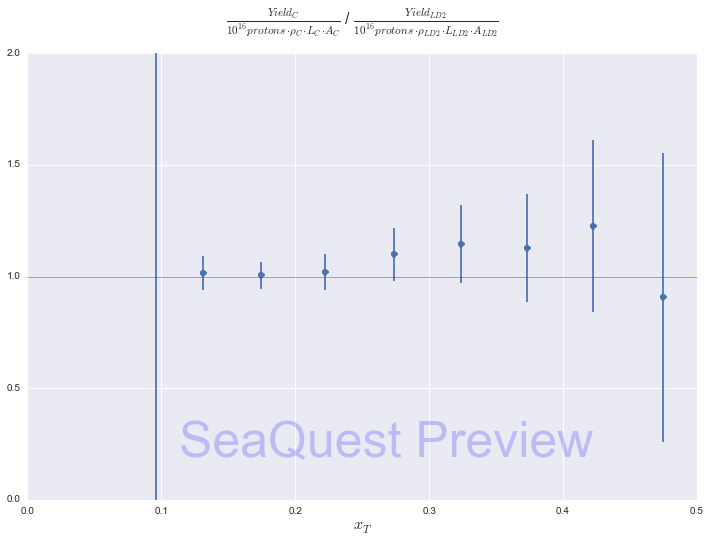

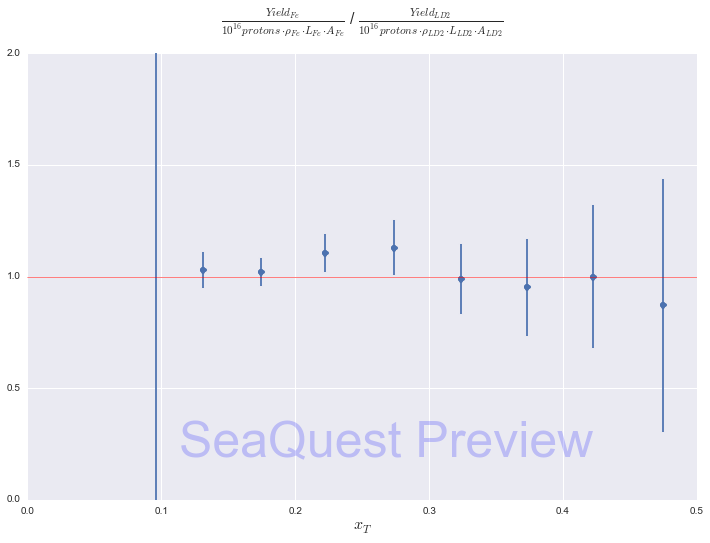

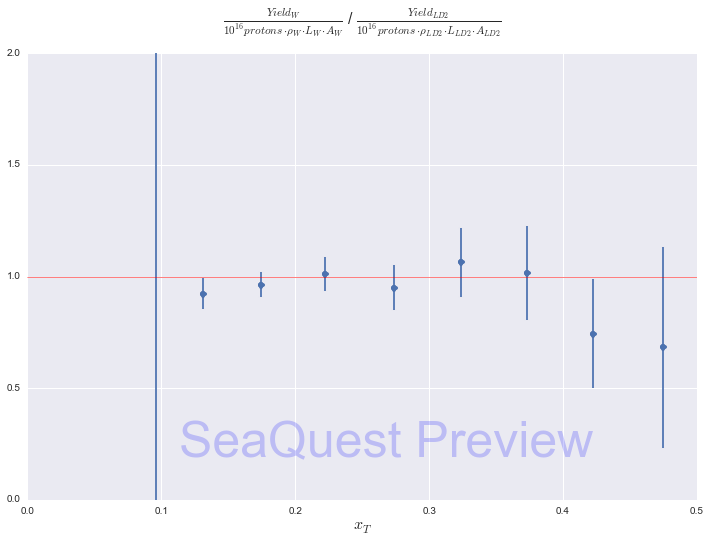

In [39]:
pylab.rcParams['figure.figsize'] = 12, 8  # that's default image size for this interactive session
plot_ratio(c_d2_ratio, hist_dict['LD2-Empty-Adjusted']['bin_centers'], 'LD2', 'C')
plot_ratio(fe_d2_ratio, hist_dict['LD2-Empty-Adjusted']['bin_centers'], 'LD2', 'Fe')
plot_ratio(w_d2_ratio, hist_dict['LD2-Empty-Adjusted']['bin_centers'], 'LD2', 'W')

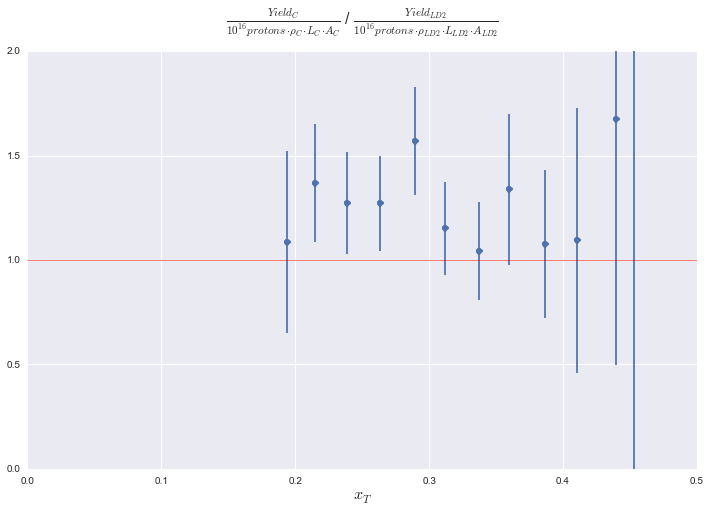

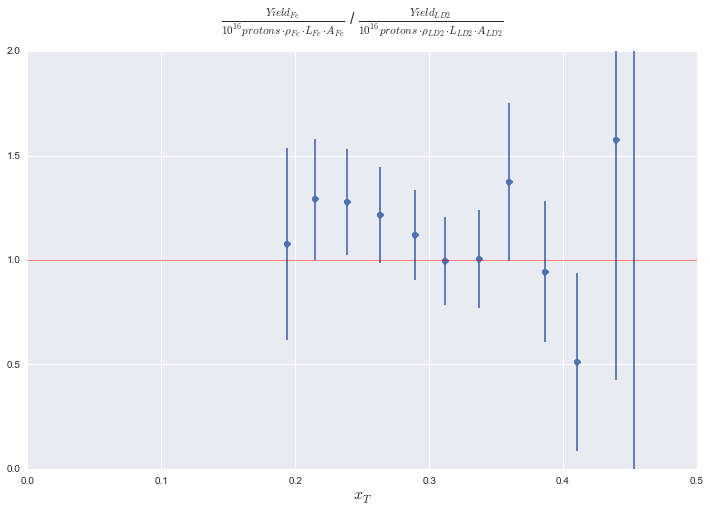

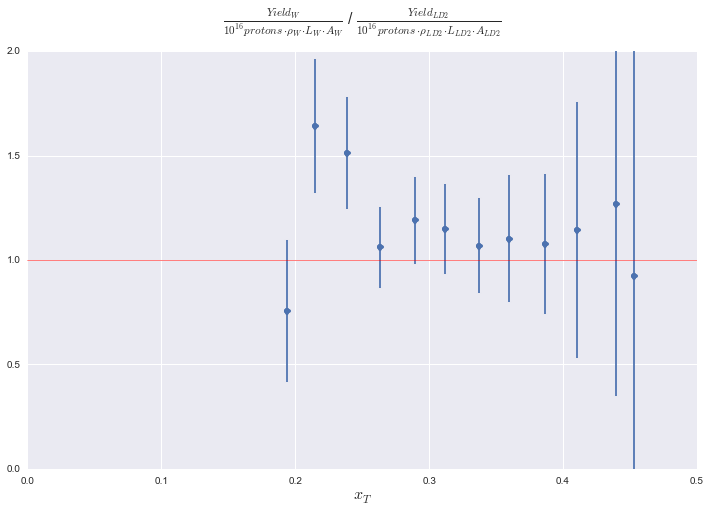

In [43]:
pylab.rcParams['figure.figsize'] = 12, 8  # that's default image size for this interactive session
plot_ratio(c_d2_ratio, hist_dict['LD2-Empty']['bin_centers'], 'LD2', 'C')
plot_ratio(fe_d2_ratio, hist_dict['LD2-Empty']['bin_centers'], 'LD2', 'Fe')
plot_ratio(w_d2_ratio, hist_dict['LD2-Empty']['bin_centers'], 'LD2', 'W')